In [1]:
# Dependencies
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
from dateutil.parser import parse

https://open.fda.gov/apis/food/enforcement/



In [2]:
# Performing a GET Request and saving the 
# API's response within a variable

with open('food.json') as json_file:
    data = json.load(json_file)


#Importing to dataframe

TotalRecall = pd.DataFrame(data['results'])

group = TotalRecall.groupby(['state'])

count = group.count()

Analysis Goals:

1.  Calculate Recall Durations and compare to notification method, and year

2.  **Ambitious** Find keywords in product description as another grouping method

3.  Group by states and see track recall frequency changes over time


In [3]:
# Calculate Recall Duration
start = pd.to_datetime(TotalRecall['recall_initiation_date'],format= '%Y%m%d', errors='ignore').values.astype('datetime64[D]')
end = pd.to_datetime(TotalRecall['termination_date'],format= '%Y%m%d', errors='ignore').values.astype('datetime64[D]')
TotalRecall['Recall Duration'] = (end - start)
TotalRecall['Recall Duration'] = TotalRecall['Recall Duration'].astype(np.int64) / 86400000000000

In [4]:
# Cleaning & Renaming Data
clean_df = TotalRecall[['classification',
                        'initial_firm_notification',
                        'recall_initiation_date',
                        'report_date',
                        'termination_date',
                        'status',
                        'Recall Duration']]
# Rename Titles
clean_df = clean_df.rename(columns = {'classification':'Class',
                                      'initial_firm_notification':'Notification Method',
                                      'recall_initiation_date':'Recall Date',
                                      'report_date':'Report Date',
                                      'termination_date':'Termination Date',
                                      'status':'Status'})

clean_df['Notification Method'] = clean_df['Notification Method'].replace(np.NaN, 'Is Null value')
clean_df.head()

,Class,Notification Method,Recall Date,Report Date,Termination Date,Status,Recall Duration
0,Class II,E-Mail,20120921,20121003,20120926,Terminated,5.0
1,Class I,Press Release,20120831,20121003,20121025,Terminated,55.0
2,Class II,Letter,20120712,20121003,20121217,Terminated,158.0
3,Class II,Letter,20120712,20121003,20121217,Terminated,158.0
4,Class II,Telephone,20120417,20121003,20130716,Terminated,455.0


In [9]:
#clean_df = clean_df.dropna(subset=['Termination Date','Recall Duration','Notification Method'])

#Removes any null value rows
clean_df = clean_df.dropna(how='any',axis=0) 

#Filter out any values that's greater than 5000
clean_df = clean_df[clean_df['Recall Duration'] < 5000]

#Assign each methods (not yet been use in any functions)
Letter = clean_df[clean_df["Notification Method"] == "Letter"]["Recall Duration"]
Email = clean_df[clean_df["Notification Method"] == "E-Mail"]["Recall Duration"]
Press = clean_df[clean_df["Notification Method"] == "Press Release"]["Recall Duration"]
Phone = clean_df[clean_df["Notification Method"] == "Telephone"]["Recall Duration"]
Visit = clean_df[clean_df["Notification Method"] == "Visit"]["Recall Duration"]
Other = clean_df[clean_df["Notification Method"] == "Other"]["Recall Duration"]
Fax = clean_df[clean_df["Notification Method"] == "FAX"]["Recall Duration"]

#Renaming the long string values
clean_df.loc[clean_df['Notification Method'] == "Two or more of the following: Email, Fax, Letter, Press Release, Telephone, Visit", ['Notification Method']] = 'Two or more Method'
clean_df

,Class,Notification Method,Recall Date,Report Date,Termination Date,Status,Recall Duration
0,Class II,E-Mail,20120921,20121003,20120926,Terminated,5.0
1,Class I,Press Release,20120831,20121003,20121025,Terminated,55.0
2,Class II,Letter,20120712,20121003,20121217,Terminated,158.0
3,Class II,Letter,20120712,20121003,20121217,Terminated,158.0
4,Class II,Telephone,20120417,20121003,20130716,Terminated,455.0
5,Class I,Press Release,20120824,20121003,20121119,Terminated,87.0
6,Class I,Two or more Method,20120830,20121003,20121204,Terminated,96.0
7,Class II,Telephone,20120828,20121010,20131018,Terminated,416.0
8,Class I,Telephone,20120831,20121010,20121220,Terminated,111.0
9,Class I,Telephone,20120828,20121010,20131018,Terminated,416.0


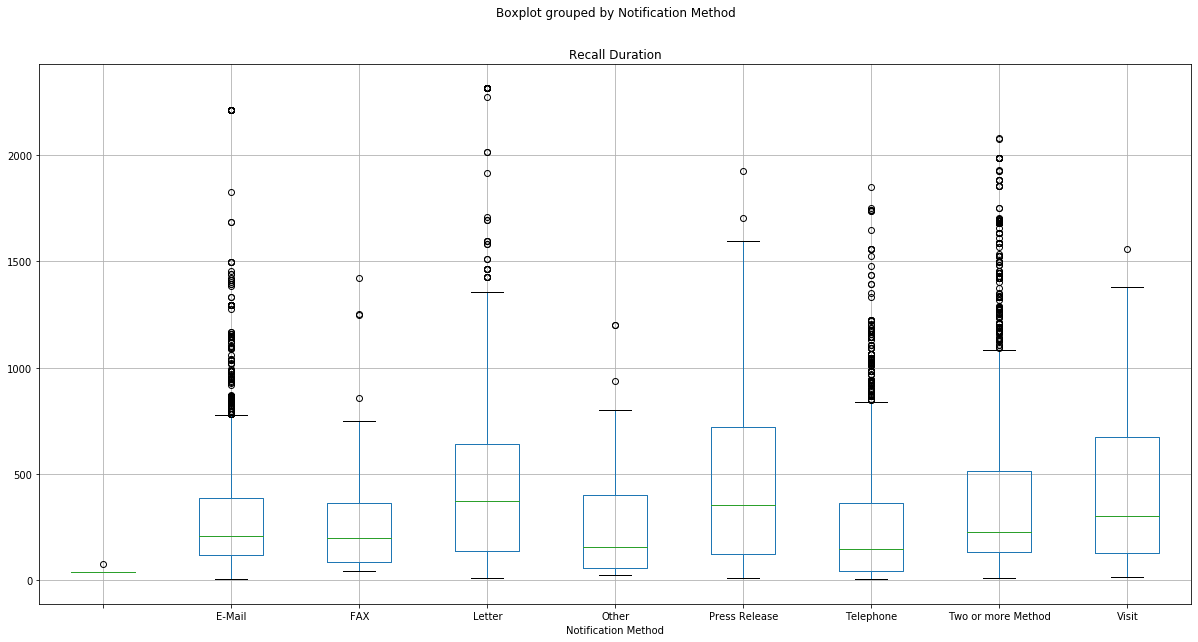

In [10]:
bxplt_method = clean_df.boxplot("Recall Duration", by = "Notification Method", figsize = (20,10))

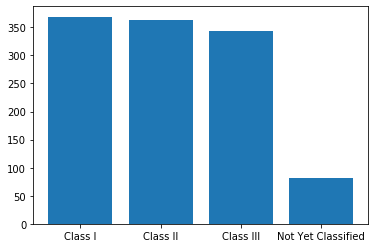

In [7]:
mean = clean_df.groupby('Class')['Recall Duration'].mean().reset_index()
mean = round(mean)
barplt_class = plt.bar(mean['Class'],mean['Recall Duration'], align="center")
plt.show()

In [8]:
#Shuo's working on progress
class1_df = clean_df.loc[clean_df["Class"]== "Class I"]
class2_df = clean_df.loc[clean_df["Class"]== "Class II"]
class3_df = clean_df.loc[clean_df["Class"]== "Class III"]
class1_df = class1_df.groupby("Notification Method")["Class"].count()
class2_df = class2_df.groupby("Notification Method")["Class"].count()
class3_df = class3_df.groupby("Notification Method")["Class"].count()
print(class1_df)


Notification Method
E-Mail                 808
FAX                     40
Letter                 858
Other                   74
Press Release         1508
Telephone              862
Two or more Method    3306
Visit                   40
Name: Class, dtype: int64
